## Download data from WandB sweep

In [1]:
import pandas as pd 
import wandb

# Get runs in the refined ES sweep
api = wandb.Api(timeout=60)
sweep = api.sweep("hericks/odql-hyperparameter-search/1psdbo3k")
runs = sweep.runs

def unique_keep_order(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

param_names = ["es_popsize", "es_lr", "es_sigma_init", "es_sigma_decay"]
run_dfs = []
for index, run in enumerate(runs):
    # Logging
    if (index + 1) % 10 == 0:
        print(index + 1)

    # Create df
    run_df = run.history()
    for param_name in param_names:
        run_df[param_name] = run.config[param_name]
    
    # Cleanup df
    run_df = run_df.drop(['_timestamp', '_runtime'], axis=1)
    run_df = run_df.reindex(unique_keep_order(param_names + sorted(run_df.columns)), axis=1)

    run_dfs.append(run_df)


runs_df = pd.concat(run_dfs)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [2]:
runs_df.columns

Index(['es_popsize', 'es_lr', 'es_sigma_init', 'es_sigma_decay', '_step',
       'center_test_eval', 'center_test_eval_0', 'center_test_eval_1',
       'center_test_eval_2', 'center_test_eval_3', 'center_test_eval_4',
       'center_train_eval', 'center_train_eval_0', 'center_train_eval_1',
       'center_train_eval_2', 'center_train_eval_3', 'center_train_eval_4',
       'mean_eval', 'mean_eval_split_0', 'mean_eval_split_1',
       'mean_eval_split_2', 'mean_eval_split_3', 'mean_eval_split_4'],
      dtype='object')

## Exploratory data analysis

In [3]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

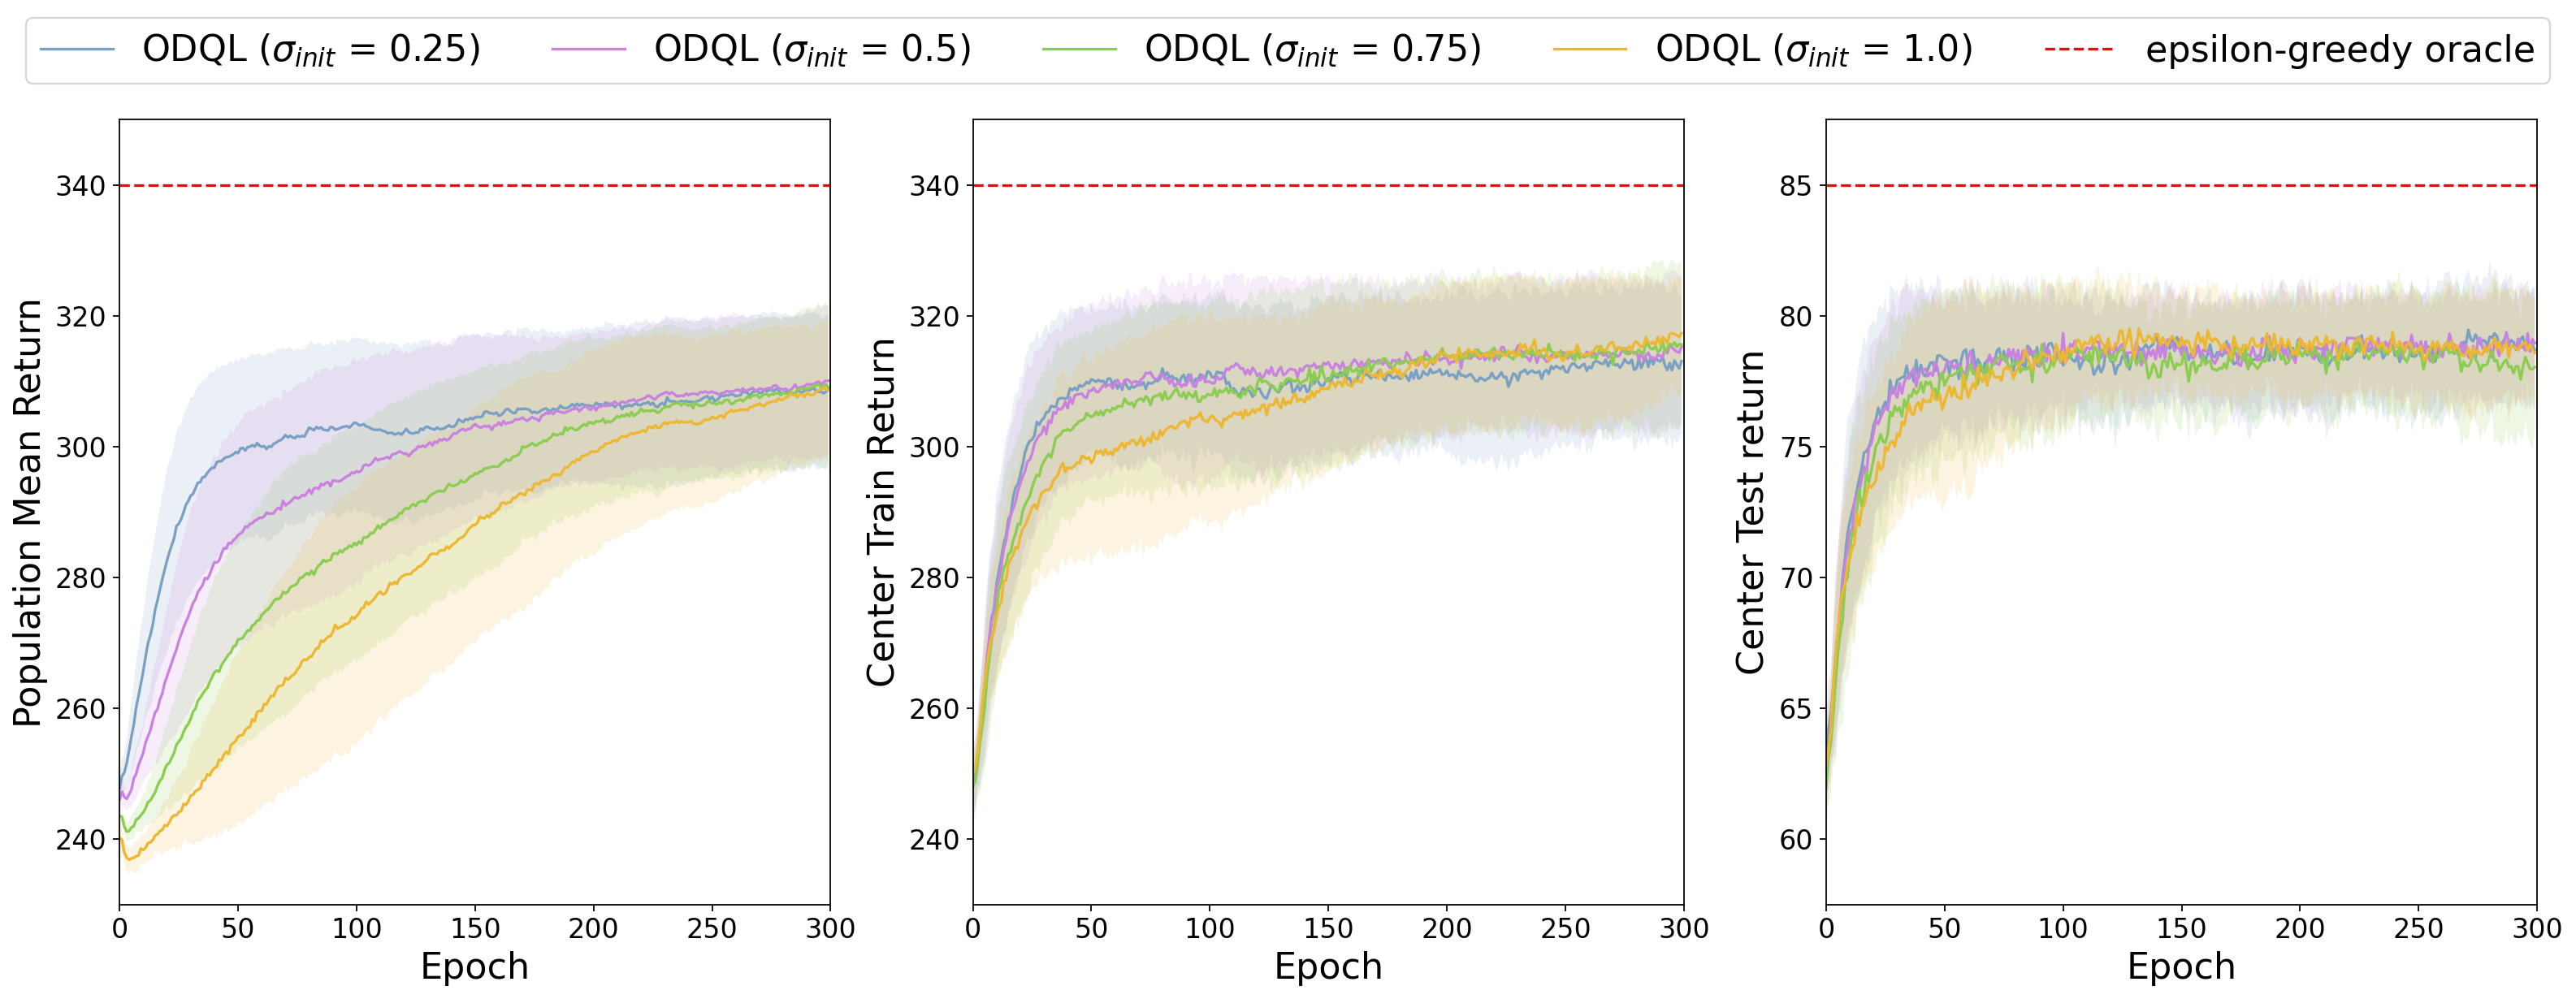

In [20]:
param_name = 'es_sigma_init'
label_name = "sigma init"

cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#EDB732", "#64b9a1", "#745ea6", "#db7e76"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cols)

# Prepare joint plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), dpi=160)

# 
params = sorted(list(set(runs_df[param_name])))
metrics = ['mean_eval', 'center_train_eval', 'center_test_eval']
metric_names = ['Population Mean Return', 'Center Train Return', 'Center Test return']
max_returns = [400, 400, 100]
epsilon = 0.3
oracles = [max_returns[i] * (1 - epsilon / 2) for i in range(3)]
xlim_lower_ratio = 230 / 400
ylim_upper_ratio = 350 / 400

ticksize = 15
fontsize = 20

for metric_idx, metric in enumerate(metrics):
    for param in params:
        # Prepare df
        filtered_df = runs_df[runs_df[param_name] == param]
        filtered_df = filtered_df.drop(param_names, axis=1)
        # Compute mean and std in each group
        results_df = filtered_df.groupby(['_step'], as_index=False).agg(['mean', 'std'], axis=1)

        # Plotting
        ax = axs[metric_idx]
        ax.plot(np.arange(results_df.shape[0]), results_df[metric]['mean'], label=r'ODQL ($\sigma_{init}$ = ' + str(param) + ')')
        ax.fill_between(
            np.arange(results_df.shape[0]),
            results_df[metric]['mean'] - results_df[metric]['std'],
            results_df[metric]['mean'] + results_df[metric]['std'],
            alpha=0.15
        )


        ax.set_xlabel('Epoch', fontsize=fontsize)
        ax.set_ylabel(metric_names[metric_idx], fontsize=fontsize)

        ax.tick_params(axis='both', which='major', labelsize=ticksize)

        ax.set_xlim((0, 300))
        ax.set_ylim((max_returns[metric_idx] * xlim_lower_ratio, max_returns[metric_idx] * ylim_upper_ratio))

    ax.axhline(y=oracles[metric_idx], color='r', linestyle='dashed', label="epsilon-greedy oracle")
        
def legend_without_duplicate_labels():
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(*zip(*unique), loc='upper center', ncol=len(params) + 1, fontsize=fontsize, borderaxespad=0.5)

legend_without_duplicate_labels()

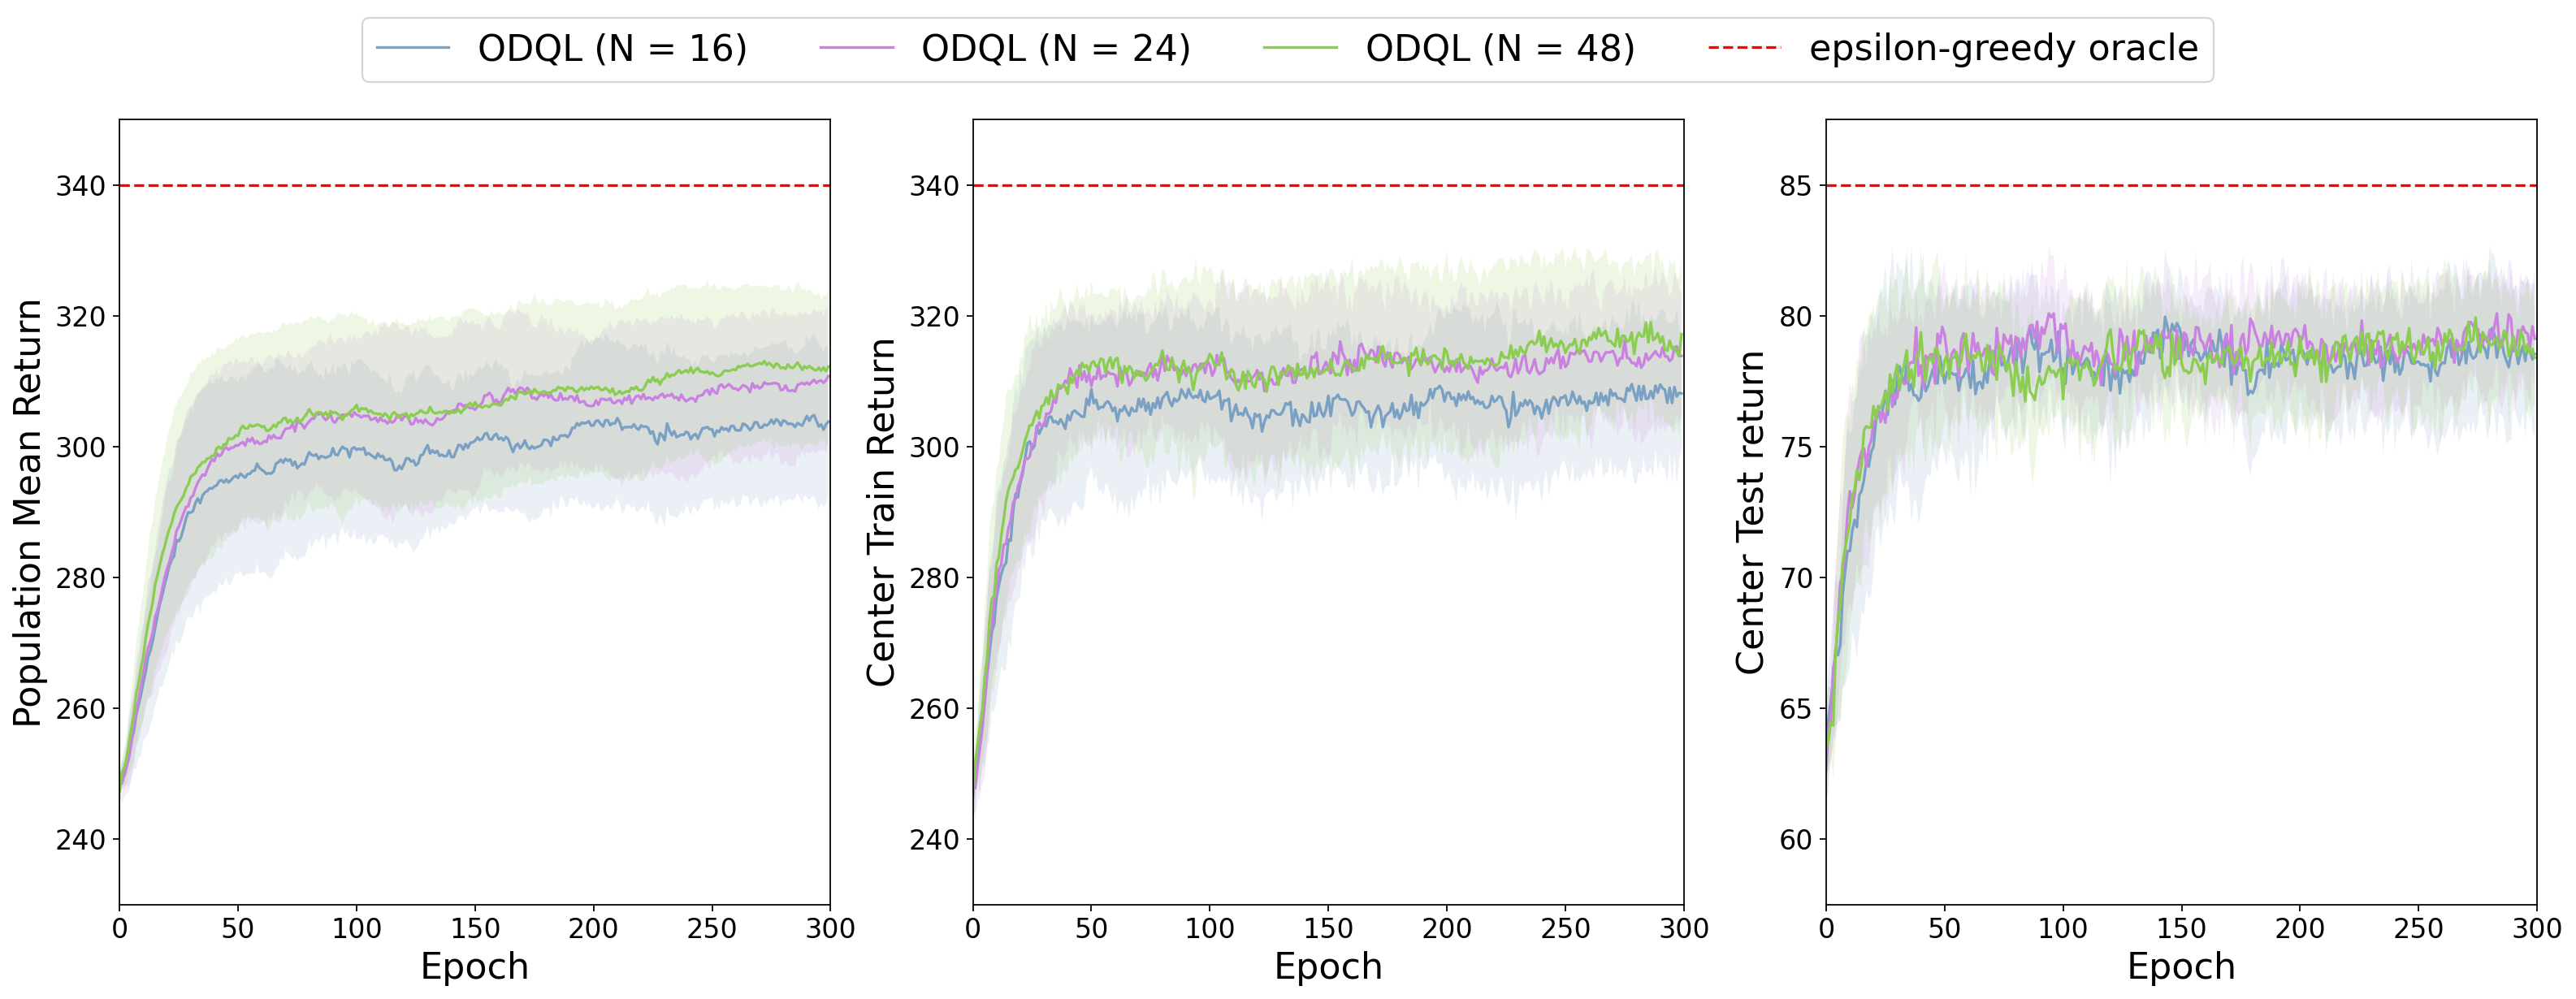

In [14]:

param_name = 'es_popsize'
label_name = "ODQL (N"

cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#EDB732", "#64b9a1", "#745ea6", "#db7e76"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cols)

# Prepare joint plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), dpi=160)

# 
params = sorted(list(set(runs_df[param_name])))
metrics = ['mean_eval', 'center_train_eval', 'center_test_eval']
metric_names = ['Population Mean Return', 'Center Train Return', 'Center Test return']
max_returns = [400, 400, 100]
epsilon = 0.3
oracles = [max_returns[i] * (1 - epsilon / 2) for i in range(3)]
xlim_lower_ratio = 230 / 400
ylim_upper_ratio = 350 / 400

ticksize = 15
fontsize = 20

for metric_idx, metric in enumerate(metrics):
    for param in params:
        # Prepare df
        filtered_df = runs_df[(runs_df[param_name] == param) & (runs_df['es_sigma_init'] == 0.25)]
        filtered_df = filtered_df.drop(param_names, axis=1)
        # Compute mean and std in each group
        results_df = filtered_df.groupby(['_step'], as_index=False).agg(['mean', 'std'], axis=1)

        # Plotting
        ax = axs[metric_idx]
        ax.plot(np.arange(results_df.shape[0]), results_df[metric]['mean'], label=label_name + ' = ' + str(param) + ')')
        ax.fill_between(
            np.arange(results_df.shape[0]),
            results_df[metric]['mean'] - results_df[metric]['std'],
            results_df[metric]['mean'] + results_df[metric]['std'],
            alpha=0.15
        )


        ax.set_xlabel('Epoch', fontsize=fontsize)
        ax.set_ylabel(metric_names[metric_idx], fontsize=fontsize)

        ax.tick_params(axis='both', which='major', labelsize=ticksize)

        ax.set_xlim((0, 300))
        ax.set_ylim((max_returns[metric_idx] * xlim_lower_ratio, max_returns[metric_idx] * ylim_upper_ratio))

    ax.axhline(y=oracles[metric_idx], color='r', linestyle='dashed', label="epsilon-greedy oracle")
        
def legend_without_duplicate_labels():
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(*zip(*unique), loc='upper center', ncol=len(params) + 1, fontsize=fontsize, borderaxespad=0.5)

legend_without_duplicate_labels()

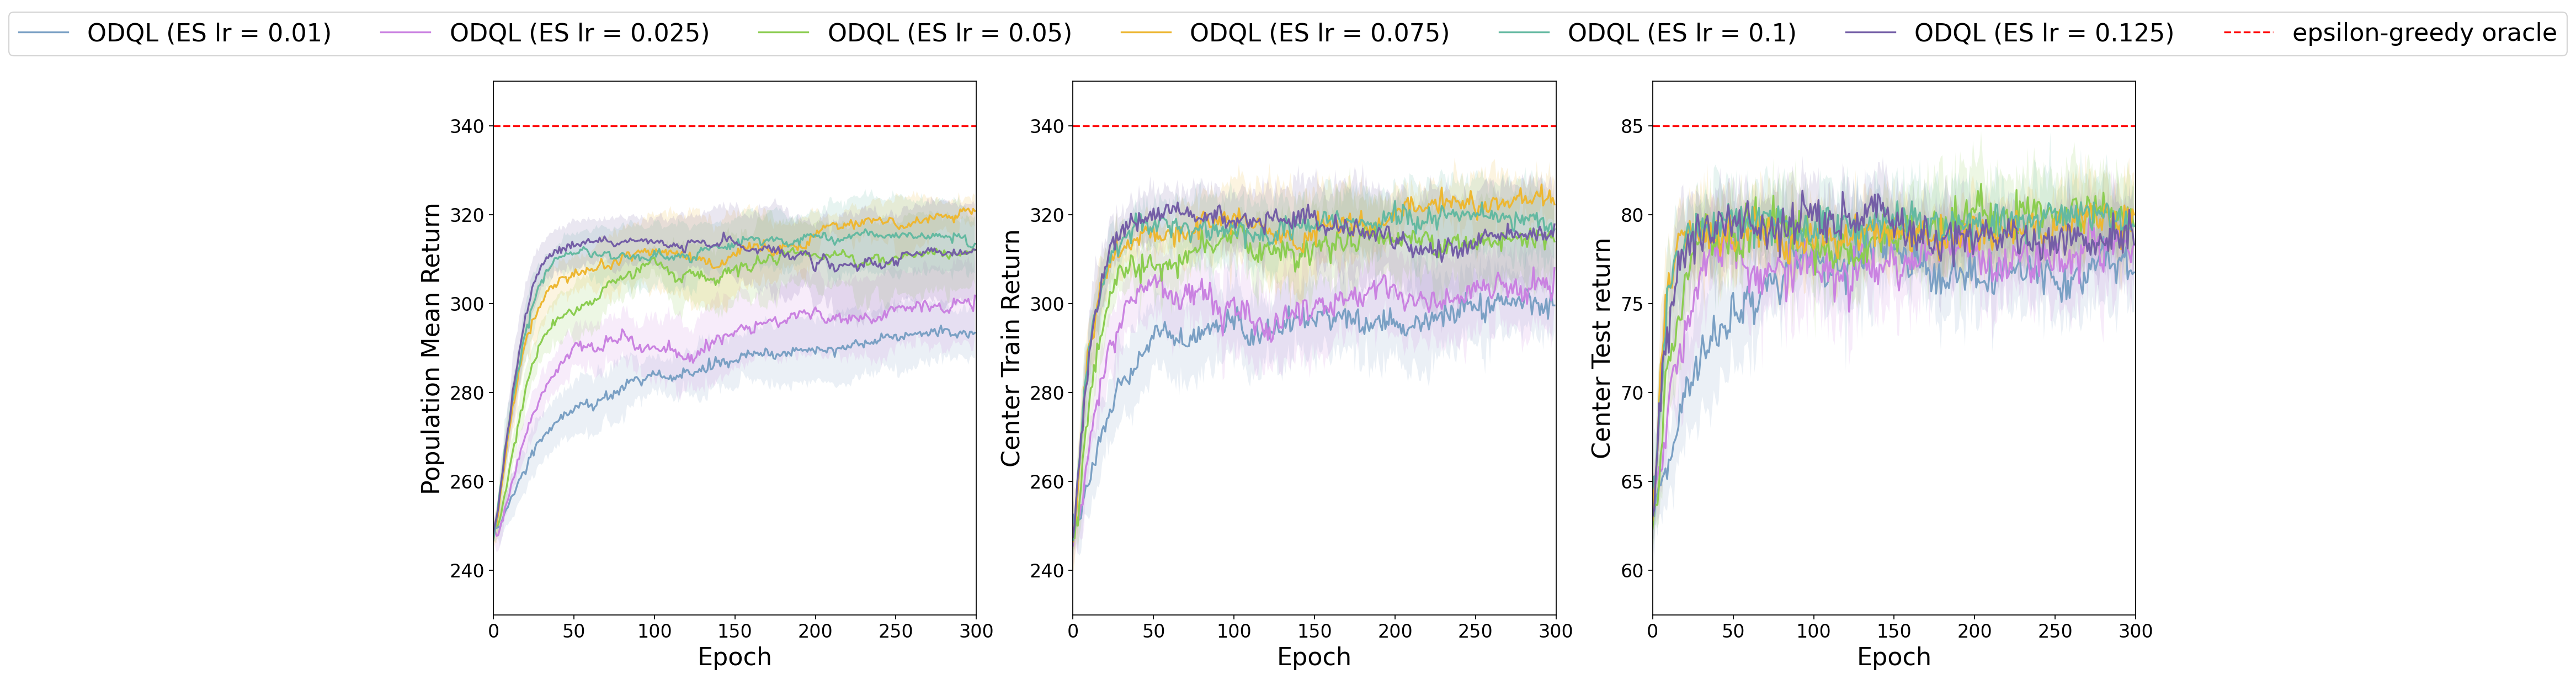

In [12]:

param_name = 'es_lr'
label_name = r"ODQL ($\alpha_{ES}$"

cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#EDB732", "#64b9a1", "#745ea6", "#db7e76"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cols)

# Prepare joint plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), dpi=160)

# 
params = sorted(list(set(runs_df[param_name])))
metrics = ['mean_eval', 'center_train_eval', 'center_test_eval']
metric_names = ['Population Mean Return', 'Center Train Return', 'Center Test return']
max_returns = [400, 400, 100]
epsilon = 0.3
oracles = [max_returns[i] * (1 - epsilon / 2) for i in range(3)]
xlim_lower_ratio = 230 / 400
ylim_upper_ratio = 350 / 400

ticksize = 15
fontsize = 20

for metric_idx, metric in enumerate(metrics):
    for param in params:
        # Prepare df
        filtered_df = runs_df[(runs_df[param_name] == param) & (runs_df['es_sigma_init'] == 0.25)]
        filtered_df = filtered_df.drop(param_names, axis=1)
        # Compute mean and std in each group
        results_df = filtered_df.groupby(['_step'], as_index=False).agg(['mean', 'std'], axis=1)

        # Plotting
        ax = axs[metric_idx]
        ax.plot(np.arange(results_df.shape[0]), results_df[metric]['mean'], label=label_name + ' = ' + str(param) + ')')
        ax.fill_between(
            np.arange(results_df.shape[0]),
            results_df[metric]['mean'] - results_df[metric]['std'],
            results_df[metric]['mean'] + results_df[metric]['std'],
            alpha=0.15
        )


        ax.set_xlabel('Epoch', fontsize=fontsize)
        ax.set_ylabel(metric_names[metric_idx], fontsize=fontsize)

        ax.tick_params(axis='both', which='major', labelsize=ticksize)

        ax.set_xlim((0, 300))
        ax.set_ylim((max_returns[metric_idx] * xlim_lower_ratio, max_returns[metric_idx] * ylim_upper_ratio))

    ax.axhline(y=oracles[metric_idx], color='r', linestyle='dashed', label="epsilon-greedy oracle")
        
def legend_without_duplicate_labels():
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(*zip(*unique), loc='upper center', ncol=len(params) + 1, fontsize=fontsize, borderaxespad=0.5)

legend_without_duplicate_labels()